In [42]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_excel
from pandas import DataFrame
from pandas import concat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential,load_model
from keras.layers import Dense
from keras.layers import LSTM

In [43]:
# load dataset
dataset = pd.read_excel('BBCA.xlsx', header=0, index_col=0)
dataset

,Close,RSI,MACD,MA,Close.1,RSI.1,MACD.1,MA.1,Close.2,RSI.2,MACD.2,MA.2,Close.3,RSI.3,MACD.3,MA.3
Date,,,,,,,,,,,,,,,,
2017-12-14,4220000000,792.93,12578252,4218333333,4.220000e+09,792.93,9904587.0,4.208333e+09,4.220000e+09,792.93,7241122.0,4.220000e+09,4.220000e+09,792.93,6467853.0,4.220000e+09
2017-12-15,4220000000,792.93,9904587,4208333333,4.220000e+09,792.93,7241122.0,4.220000e+09,4.220000e+09,792.93,6467853.0,4.220000e+09,4.185000e+09,340.83,12454975.0,4.208333e+09
2017-12-18,4220000000,792.93,7241122,4220000000,4.220000e+09,792.93,6467853.0,4.220000e+09,4.185000e+09,340.83,12454975.0,4.208333e+09,4.220000e+09,1042.11,23698959.0,4.208333e+09
2017-12-19,4220000000,792.93,6467853,4220000000,4.185000e+09,340.83,12454975.0,4.208333e+09,4.220000e+09,1042.11,23698959.0,4.208333e+09,4.300000e+09,491.70,39588703.0,4.235000e+09
2017-12-20,4185000000,340.83,12454975,4208333333,4.220000e+09,1042.11,23698959.0,4.208333e+09,4.300000e+09,491.70,39588703.0,4.235000e+09,4.300000e+09,491.70,50219257.0,4.273333e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-02,8750000000,319.26,317268377,8783333333,8.800000e+09,278.94,346150661.0,8.783333e+09,8.775000e+09,309.60,367256147.0,8.775000e+09,8.850000e+09,254.68,393424192.0,8.808333e+09
2022-11-03,8800000000,278.94,346150661,8783333333,8.775000e+09,309.60,367256147.0,8.775000e+09,8.850000e+09,254.68,393424192.0,8.808333e+09,8.750000e+09,408.30,402177798.0,8.791667e+09
2022-11-04,8775000000,309.60,367256147,8775000000,8.850000e+09,254.68,393424192.0,8.808333e+09,8.750000e+09,408.30,402177798.0,8.791667e+09,NaN,NaN,NaN,NaN


In [44]:
values = dataset.values
values

array([[4.22000000e+09, 7.92930000e+02, 1.25782520e+07, ...,
        7.92930000e+02, 6.46785300e+06, 4.22000000e+09],
       [4.22000000e+09, 7.92930000e+02, 9.90458700e+06, ...,
        3.40830000e+02, 1.24549750e+07, 4.20833333e+09],
       [4.22000000e+09, 7.92930000e+02, 7.24112200e+06, ...,
        1.04211000e+03, 2.36989590e+07, 4.20833333e+09],
       ...,
       [8.77500000e+09, 3.09600000e+02, 3.67256147e+08, ...,
                   nan,            nan,            nan],
       [8.85000000e+09, 2.54680000e+02, 3.93424192e+08, ...,
                   nan,            nan,            nan],
       [8.75000000e+09, 4.08300000e+02, 4.02177798e+08, ...,
                   nan,            nan,            nan]])

In [45]:
growth_v = ((values[-1] - values[-244]) / values[-244]) * 100
print("Growth Ratio Valid : ", growth_v, "percent")

Growth Ratio Valid :  [14.00651466 93.97596085  0.87090279 14.67391304         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan] percent


In [46]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [47]:
# ensure all data is float
values = values.astype('float32')

In [48]:
# normalize features
scaler = MinMaxScaler(feature_range=(0.1, 0.9))
scaled = scaler.fit_transform(values)

In [49]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t)
1,0.116736,0.101025,0.106836,0.102606,0.116736,0.101025,0.105308,0.100869,0.116736,0.101025,...,0.103786,0.102895,0.116736,0.101025,0.103344,0.102895,0.110879,0.100424,0.106765,0.100869
2,0.116736,0.101025,0.105308,0.100869,0.116736,0.101025,0.103786,0.102895,0.116736,0.101025,...,0.103344,0.102895,0.110879,0.100424,0.106765,0.100869,0.116736,0.101356,0.113191,0.100869
3,0.116736,0.101025,0.103786,0.102895,0.116736,0.101025,0.103344,0.102895,0.110879,0.100424,...,0.106765,0.100869,0.116736,0.101356,0.113191,0.100869,0.130126,0.100624,0.122272,0.105501
4,0.116736,0.101025,0.103344,0.102895,0.110879,0.100424,0.106765,0.100869,0.116736,0.101356,...,0.113191,0.100869,0.130126,0.100624,0.122272,0.105501,0.130126,0.100624,0.128347,0.112161
5,0.110879,0.100424,0.106765,0.100869,0.116736,0.101356,0.113191,0.100869,0.130126,0.100624,...,0.122272,0.105501,0.130126,0.100624,0.128347,0.112161,0.130126,0.100624,0.130891,0.116793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,0.866527,0.100410,0.205277,0.872494,0.874895,0.100360,0.226104,0.875389,0.883264,0.100322,...,0.250423,0.889866,0.883264,0.100322,0.268166,0.895657,0.874895,0.100395,0.280960,0.895657
1221,0.874895,0.100360,0.226104,0.875389,0.883264,0.100322,0.250423,0.889866,0.883264,0.100322,...,0.268166,0.895657,0.874895,0.100395,0.280960,0.895657,0.883264,0.100342,0.297466,0.895657
1222,0.883264,0.100322,0.250423,0.889866,0.883264,0.100322,0.268166,0.895657,0.874895,0.100395,...,0.280960,0.895657,0.883264,0.100342,0.297466,0.895657,0.879080,0.100382,0.309527,0.894209
1223,0.883264,0.100322,0.268166,0.895657,0.874895,0.100395,0.280960,0.895657,0.883264,0.100342,...,0.297466,0.895657,0.879080,0.100382,0.309527,0.894209,0.891632,0.100310,0.324482,0.900000


In [50]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.116736   0.101025   0.106836   0.102606   0.116736   0.101025   
2   0.116736   0.101025   0.105308   0.100869   0.116736   0.101025   
3   0.116736   0.101025   0.103786   0.102895   0.116736   0.101025   
4   0.116736   0.101025   0.103344   0.102895   0.110879   0.100424   
5   0.110879   0.100424   0.106765   0.100869   0.116736   0.101356   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.105308   0.100869   0.116736    0.101025    0.103786    0.102895   
2   0.103786   0.102895   0.116736    0.101025    0.103344    0.102895   
3   0.103344   0.102895   0.110879    0.100424    0.106765    0.100869   
4   0.106765   0.100869   0.116736    0.101356    0.113191    0.100869   
5   0.113191   0.100869   0.130126    0.100624    0.122272    0.105501   

   var13(t-1)  var14(t-1)  var15(t-1)  var16(t-1)   var1(t)  
1    0.116736    0.101025    0.103344    0.102895  0.116736  
2   

In [51]:
# split into train and test sets
values = reframed.values
n_train = 981
train = values[:n_train, :]
test = values[n_train:, :]

In [52]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [53]:
print(test_y)

[0.6949791  0.69079506 0.6949791  0.66987455 0.6656904  0.6615063
 0.6782427  0.64895403 0.65313816 0.6615063  0.6615063  0.6615063
 0.65313816 0.6280335  0.64895403 0.6280335  0.6322175  0.6656904
 0.6447699  0.6405859  0.6405859  0.65313816 0.6405859  0.6447699
 0.6322175  0.6322175  0.6322175  0.6280335  0.6656904  0.6447699
 0.6447699  0.6364018  0.6322175  0.6322175  0.6405859  0.6405859
 0.6322175  0.6322175  0.6364018  0.64895403 0.65732217 0.6615063
 0.69079506 0.6824268  0.6991632  0.6991632  0.6991632  0.72426784
 0.70753145 0.6949791  0.6949791  0.7117156  0.7410042  0.7158996
 0.7117156  0.6991632  0.7158996  0.7117156  0.68661094 0.7158996
 0.7033473  0.7033473  0.7158996  0.7033473  0.7410042  0.70753145
 0.7200837  0.6991632  0.72845185 0.74518836 0.7326361  0.7368202
 0.7410042  0.7326361  0.7577406  0.7493725  0.7577406  0.7577406
 0.74518836 0.7326361  0.6991632  0.69079506 0.72426784 0.7368202
 0.7410042  0.76192474 0.774477   0.78284526 0.7493725  0.7326361
 0.73263

In [54]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(981, 1, 16) (981,) (243, 1, 16) (243,)


In [55]:
print(test_y)

[0.6949791  0.69079506 0.6949791  0.66987455 0.6656904  0.6615063
 0.6782427  0.64895403 0.65313816 0.6615063  0.6615063  0.6615063
 0.65313816 0.6280335  0.64895403 0.6280335  0.6322175  0.6656904
 0.6447699  0.6405859  0.6405859  0.65313816 0.6405859  0.6447699
 0.6322175  0.6322175  0.6322175  0.6280335  0.6656904  0.6447699
 0.6447699  0.6364018  0.6322175  0.6322175  0.6405859  0.6405859
 0.6322175  0.6322175  0.6364018  0.64895403 0.65732217 0.6615063
 0.69079506 0.6824268  0.6991632  0.6991632  0.6991632  0.72426784
 0.70753145 0.6949791  0.6949791  0.7117156  0.7410042  0.7158996
 0.7117156  0.6991632  0.7158996  0.7117156  0.68661094 0.7158996
 0.7033473  0.7033473  0.7158996  0.7033473  0.7410042  0.70753145
 0.7200837  0.6991632  0.72845185 0.74518836 0.7326361  0.7368202
 0.7410042  0.7326361  0.7577406  0.7493725  0.7577406  0.7577406
 0.74518836 0.7326361  0.6991632  0.69079506 0.72426784 0.7368202
 0.7410042  0.76192474 0.774477   0.78284526 0.7493725  0.7326361
 0.73263

In [56]:
# design network
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [57]:
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
model.save('./savedModel')

Epoch 1/500
14/14 - 4s - loss: 0.1566 - val_loss: 0.4362 - 4s/epoch - 265ms/step
Epoch 2/500
14/14 - 0s - loss: 0.0707 - val_loss: 0.2270 - 121ms/epoch - 9ms/step
Epoch 3/500
14/14 - 0s - loss: 0.0247 - val_loss: 0.0998 - 120ms/epoch - 9ms/step
Epoch 4/500
14/14 - 0s - loss: 0.0076 - val_loss: 0.0398 - 122ms/epoch - 9ms/step
Epoch 5/500
14/14 - 0s - loss: 0.0056 - val_loss: 0.0212 - 78ms/epoch - 6ms/step
Epoch 6/500
14/14 - 0s - loss: 0.0061 - val_loss: 0.0191 - 73ms/epoch - 5ms/step
Epoch 7/500
14/14 - 0s - loss: 0.0057 - val_loss: 0.0203 - 88ms/epoch - 6ms/step
Epoch 8/500
14/14 - 0s - loss: 0.0051 - val_loss: 0.0199 - 76ms/epoch - 5ms/step
Epoch 9/500
14/14 - 0s - loss: 0.0046 - val_loss: 0.0176 - 92ms/epoch - 7ms/step
Epoch 10/500
14/14 - 0s - loss: 0.0042 - val_loss: 0.0151 - 80ms/epoch - 6ms/step
Epoch 11/500
14/14 - 0s - loss: 0.0038 - val_loss: 0.0131 - 83ms/epoch - 6ms/step
Epoch 12/500
14/14 - 0s - loss: 0.0034 - val_loss: 0.0113 - 77ms/epoch - 6ms/step
Epoch 13/500
14/14 - 0

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                2960      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,981
Trainable params: 2,981
Non-trainable params: 0
_________________________________________________________________


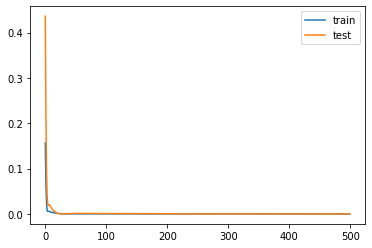

In [60]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [61]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

8/8 [==============================] - 1s 3ms/step


In [62]:
# invert scaling for predict
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [63]:
print("Price for last 5 days: ")
print(inv_yhat[-5:])

Price for last 5 days: 
[8.605455e+09 8.654842e+09 8.648435e+09 8.628045e+09 8.646155e+09]


In [64]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

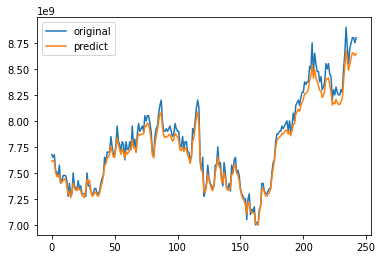

In [65]:
pyplot.plot(inv_y, label="original")
pyplot.plot(inv_yhat, label="predict")
pyplot.legend(loc="best")

In [66]:
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100
mape

0.7486446760594845

REKOMENDASI HARGA BELI 1 LEMBAR SAHAM 30 HARI TERAKHIR

In [67]:
print((inv_yhat[-5:]))
print((inv_y[-5:]))

[8.605455e+09 8.654842e+09 8.648435e+09 8.628045e+09 8.646155e+09]
[8.75e+09 8.80e+09 8.80e+09 8.75e+09 8.80e+09]


GROWTH RATIO HASIL PREDIKSI

PRESENT - PAST / PAST X 100

GROWTH RATIO VALID

In [68]:
units = int(int(model.layers[0].trainable_weights[0].shape[1])/4)

In [69]:
W = model.layers[0].get_weights()[0]
b = model.layers[0].get_weights()[2]

In [70]:
#The weight of the first variable (Price) for the input gate, forget gate, cell state, and output gate.
W_i = W[:, :units]
W_f = W[:, units: units * 2]
W_c = W[:, units * 2: units * 3]
W_o = W[:, units * 3:]

In [71]:
W_i[0]

array([ 0.25208303,  0.0057444 , -0.11545288, -0.10329702,  0.04895525,
       -0.28553888,  0.17003027,  0.24665199, -0.11641421, -0.08252719,
       -0.10351834,  0.09582643,  0.0334974 , -0.08553772, -0.33024526,
        0.1546947 , -0.21477154,  0.14991385,  0.06266756,  0.18731432],
      dtype=float32)

In [72]:
W_f[0]

array([ 0.07267249, -0.12302166,  0.15687251,  0.1767081 ,  0.19482672,
        0.22235751, -0.03716213,  0.07795554, -0.07470542,  0.10313749,
        0.23876452,  0.1849618 ,  0.21915317, -0.09320742,  0.06020969,
       -0.24253148,  0.17383093,  0.23527455,  0.02815598,  0.15097523],
      dtype=float32)

In [73]:
W_c[0]

array([-0.19069959,  0.05861103, -0.00546981,  0.0814303 , -0.06362227,
       -0.16424336,  0.00437789,  0.26522407, -0.07926761, -0.00182809,
       -0.24559666, -0.12493983, -0.07925536,  0.07781606, -0.20441043,
       -0.023131  ,  0.01366144,  0.18540643, -0.03458315, -0.15488955],
      dtype=float32)

In [74]:
W_o[0]

array([-0.06863341,  0.1718789 , -0.18260562,  0.048273  ,  0.1304177 ,
       -0.31741545,  0.1896889 , -0.1553402 , -0.15604156, -0.22933388,
        0.23594098,  0.09266277,  0.03211533,  0.13065836, -0.27180633,
       -0.06611243,  0.07459365,  0.20285304, -0.18286654, -0.25691202],
      dtype=float32)

In [75]:
#Displays bias for input gate, forget gate, cell state, and gate output. 
#The number of biases corresponds to the number of neurons used, which is 20 so that when added up there are 80 biases in total.

b_i = b[:units]
b_f = b[units: units * 2]
b_c = b[units * 2: units * 3]
b_o = b[units * 3:]

In [76]:
b_i

array([ 0.14294095, -0.10460392, -0.0752605 , -0.08492419,  0.04440569,
       -0.10228113, -0.0358293 ,  0.08405065,  0.14147168,  0.0278844 ,
        0.05928914, -0.06134854, -0.00168815,  0.01453271,  0.03761846,
        0.04991752,  0.14199947,  0.02268917,  0.07411804,  0.05058236],
      dtype=float32)

In [77]:
b_f

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.], dtype=float32)

In [78]:
b_c

array([ 0.00319942, -0.00140565,  0.0109388 , -0.01190301,  0.02515497,
       -0.0159464 , -0.02278681,  0.01130736, -0.04030058,  0.01186848,
        0.01024246,  0.01254598, -0.01281706,  0.00467173,  0.01339261,
       -0.00780447,  0.00862697,  0.01503529,  0.01105803,  0.01472377],
      dtype=float32)

In [79]:
b_o

array([ 0.13357425, -0.11226261, -0.06519795, -0.08219175,  0.04188885,
       -0.08470501, -0.03632121,  0.07885855,  0.09558661,  0.0334928 ,
        0.05489532, -0.06068493,  0.00265977,  0.02041161,  0.02473037,
        0.04187766,  0.1559667 ,  0.02072377,  0.06652518,  0.05680719],
      dtype=float32)